In [1]:
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import sys
import pyBigWig

import matplotlib.pyplot as plt


# model input and output lengths
in_window = 2114
out_window = 1000


# filepaths -- Shreya can change to what she names the files she downloads

genes_list_path = "genes_to_screen.csv"  # from Shreya

candidate_promoter_regions_bed = "TSS_windows.merge.bed" # made by expanding windows around gene TSSs

procapnet_preds_pos_strand_bigwig = "tracks_v2/TSS_windows.preds.pos.bigWig"
procapnet_preds_neg_strand_bigwig = "tracks_v2/TSS_windows.preds.neg.bigWig"

In [2]:
def load_data(plus_bw_path, minus_bw_path, peak_path,
                       verbose=False):

    signals = []
    out_width = out_window // 2

    names = ['chrom', 'start', 'end']
    assert os.path.exists(peak_path), peak_path
    peaks = pd.read_csv(peak_path, sep="\t", usecols=(0, 1, 2), 
        header=None, index_col=False, names=names)

    assert os.path.exists(plus_bw_path), plus_bw_path
    assert os.path.exists(minus_bw_path), minus_bw_path
    plus_bw = pyBigWig.open(plus_bw_path, "r")
    minus_bw = pyBigWig.open(minus_bw_path, "r")

    # loop through all the candidate promoter region coordinates
    for _, (chrom, og_start, og_end) in tqdm(peaks.iterrows(), disable=True):
        start = max(0, og_start - out_width)
        end = og_end + out_width
        assert start >= 0, start

        # Load plus strand signal
        plus_sig = plus_bw.values(chrom, start, end, numpy=True)
        plus_sig = np.nan_to_num(plus_sig)

        # Load minus strand signal
        minus_sig = minus_bw.values(chrom, start, end, numpy=True)
        minus_sig = np.nan_to_num(minus_sig)

        # Append signal to growing signal list
        assert len(plus_sig) == end - start, (len(plus_sig), start, end)
        assert len(minus_sig) == end - start, (len(minus_sig), start, end)
        signals.append(np.array([plus_sig, minus_sig]))
    
    to_print = "Peak filepath: " + peak_path
    to_print += "\nNum. examples loaded: " + str(len(signals))
    print(to_print)
    sys.stdout.flush()

    return signals


predictions = load_data(procapnet_preds_pos_strand_bigwig,
                       procapnet_preds_neg_strand_bigwig,
                       candidate_promoter_regions_bed)

Peak filepath: TSS_windows.merge.bed
Num. examples loaded: 228


In [3]:
# predictions is list of PRO-cap predictions, one per candidate promoter region
# each prediction is a numpy array of shape (num_strands, length)
len(predictions), predictions[0].shape

(228, (2, 7622))

In [4]:
# to figure out which promoter regions are predicted to have the most signal:

# first, load in the coordinates for all of these regions

def load_coords_ragged(bed_file):
    # loads bed file into list of regions, 1 element in list = 1 row of file
    lines = []
    if bed_file.endswith(".gz"):
        with gzip.open(bed_file) as f:
            lines = [line.decode().split() for line in f]
    else:
        with open(bed_file) as f:
            lines = [line.split() for line in f]
            
    # logic of how much to extend the coordinates in the file by on either end
    # (this is consistent with how the data is loaded in above)
    
    coords = []
    for line in lines:
        chrom, start, end, gene_name, strand = line[0], int(line[1]), int(line[2]), line[3], line[-1]
        
        peak_len = end - start
        preds_len = peak_len + out_window
        mid = start + (end - start) // 2
        
        # last coord is calculated weird because of odd-length windows
        coord = (chrom, mid - preds_len // 2, mid - preds_len // 2 + preds_len, gene_name, strand)
        if coord[1] < 0:
            coord = (chrom, 0 + (in_window - out_window) // 2, mid - preds_len // 2 + preds_len, gene_name, strand)
        coords.append(coord)

    return np.array(coords, dtype=object)


coords = load_coords_ragged(candidate_promoter_regions_bed)

In [5]:
len(coords), coords[0]

(228, array(['chr1', 628574, 636196, 'MTATP6P1,MTCO1P12', '+'], dtype=object))

In [6]:
# most basic way of ranking promoters would be by taking the sum of the predictions
# in the window around the TSS...
pred_procap_at_promoters = np.array([pred.sum() for pred in predictions])

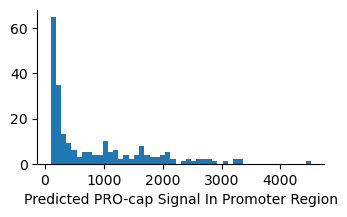

In [7]:
plt.figure(figsize=(3.7,2))
plt.hist(pred_procap_at_promoters, bins=50)
plt.xlabel("Predicted PRO-cap Signal In Promoter Region")
plt.gca().spines[["top", "right"]].set_visible(False)
plt.show()

In [8]:
# but does this depend on how wide the window was when I made predictions?
# (the window was wider if there were multiple alt TSSs/promoters nearby)
window_len_at_promoters = np.array([pred.shape[-1] for pred in predictions])

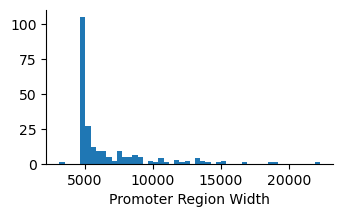

In [9]:
plt.figure(figsize=(3.7,2))
plt.hist(window_len_at_promoters, bins=50)
plt.xlabel("Promoter Region Width")
plt.gca().spines[["top", "right"]].set_visible(False)
plt.show()

In [10]:
print(np.corrcoef(window_len_at_promoters, pred_procap_at_promoters)[0,1])

0.3423034345284161


In [11]:
# might need to be more sophisticated than "which window has most signal overall"
# if window size and total signal are correlated
# ... and also we should probably take strand into account...

# so we can instead rank windows by max local signal

mini_window_max_signals = []
# for each candidate promoter region...
for pred, coord in zip(predictions, coords):
    # only care about predictions on sense strand (where gene is)
    strand = coord[-1]
    if strand == "+":
        pred = pred[0]
    else:
        pred = pred[1]
        
    # sum up signal in 50bp mini-windows across the whole region,
    # then take the max signal seen in any mini-window
    
    sliding_window_len = 50
    mini_window_signal = []
    for i in range(len(pred) - sliding_window_len):
        mini_window_signal.append(pred[i:i + sliding_window_len].sum())
    
    mini_window_max_signals.append(max(mini_window_signal))
    
# this should be a better ranking metric
mini_window_max_signals = np.array(mini_window_max_signals)

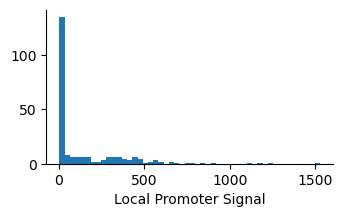

In [12]:
plt.figure(figsize=(3.7,2))
plt.hist(mini_window_max_signals, bins=50)
plt.xlabel("Local Promoter Signal")
plt.gca().spines[["top", "right"]].set_visible(False)
plt.show()

In [13]:
# this command gives us the order for sorting promoter regions by signal strength
# so the first element is the index of the strongest promoter,
# the second element is the seond-strongest promoter, etc.
promoter_region_indexes_sorted_by_signal = np.argsort(mini_window_max_signals)[::-1]
print(mini_window_max_signals[promoter_region_indexes_sorted_by_signal[:5]])  # matches histogram max

[1528.7479  1227.1544  1186.0095  1114.8605   896.39606]


In [14]:
# then, we just sort the coordinates by the sorting order for the predicted signal
coords_sorted_by_signal = coords[promoter_region_indexes_sorted_by_signal]

In [15]:
# this gives the top 10 strongest promoters
coords_sorted_by_signal[:10]

array([['chr5', 179613787, 179627169, 'HNRNPH1', '-'],
       ['chr7', 44794180, 44801314, 'PPIA', '+'],
       ['chr11', 66614126, 66621545, 'RBM14', '+'],
       ['chr16', 2750126, 2755943, 'SRRM2', '+'],
       ['chr2', 197432516, 197437579, 'SF3B1', '-'],
       ['chr19', 58276455, 58281455, 'ZNF8', '+'],
       ['chr11', 64775260, 64781286, 'SF1', '-'],
       ['chr6', 13612835, 13618089, 'NOL7', '+'],
       ['chr16', 2261831, 2270897, 'RNPS1', '-'],
       ['chr11', 57710093, 57715125, 'TMX2', '+']], dtype=object)